## Метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой)

### Общая схема метода обратного распространения ошибки

Инициализация синаптических весов сети (случайным образом из некоторого распределения)  
Повторение следующих шагов для каждого примера 
тренировочного набора данных
1. Прямой проход:
* Вычисление значений выходных сигналов нейронов всех слоев
* Вычисление значений производных функций активации на каждом слое сети
2. Обратный проход:
* Вычисление значения целевой функции и ее градиента
* Корректировка синаптических весов  


In [1]:
import time
import numpy as np
import random
from keras.datasets import mnist
from keras.utils import np_utils
from matplotlib import pyplot as plt
import torch
import torch.nn

Number of train samples: 60000
Number of test samples: 10000


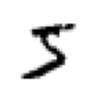

In [2]:
batch_size = 16 # на каждой итерации рассматриваем сразу 16 обучающих примеров
num_epochs = 20 # повторяем 20 раз по всему набору тренировок

w, h = 28, 28 # изображения MNIST имеют размер 28x28
num_classes = 10 # существует 10 классов (по 1 на цифру)
hidden_neurons = 300 # количество скрытых нейронов
learning_rate = 0.1 # скорость обучения

(X_train, y_train), (X_test, y_test) = mnist.load_data() # извлекаем данные MNIST

# Выведем на экран хранящееся в X_train[0] изображение
fig = plt.figure(figsize = (1, 1))
plt.imshow(X_train[0], cmap = 'binary')
plt.axis('off')

X_train = X_train.reshape(X_train.shape[0], w * h)
X_test = X_test.reshape(X_test.shape[0], w * h)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255 # нормализуем данные до диапазона [0, 1]
X_test /= 255 # Нормализуем данные до диапазона [0, 1]

y_train = np_utils.to_categorical(y_train, num_classes) # кодирование меток
y_test = np_utils.to_categorical(y_test, num_classes) # кодирование меток

print('Number of train samples: {}'.format(len(X_train)))
print('Number of test samples: {}'.format(len(X_test)))

In [3]:
# функция активации на скрытом слое
def ReLU(x):
    return np.maximum(0, x)

# функция активации на выходном слое
def softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis = 1, keepdims = True)

# функция ошибки
def crossEntropyLoss(y, u):
    return np.mean(-np.sum(y * np.log(u), axis = 1))

def get_accuracy(x, y):
    return np.mean(np.argmax(x, axis = 1) == np.argmax(y, axis = 1))

In [4]:
class myNNetwork:
    # конструктор класса
    def __init__(self,
            num_of_neurons_input, # количество нейронов на входе
            num_of_neurons_hidden_layer, # количество нейронов на скрытом слое
            num_of_neurons_output, # количество нейронов на выходе
            batch_size, # размер пачки
            learning_rate # скорость обучения
                ):
        
        self.W1 = np.random.randn(num_of_neurons_input, num_of_neurons_hidden_layer) * 0.01
        self.W2 = np.random.randn(num_of_neurons_hidden_layer, num_of_neurons_output) * 0.01
        self.b1 = np.zeros((1, num_of_neurons_hidden_layer))
        self.b2 = np.zeros((1, num_of_neurons_output))
        self.batch_size = batch_size
        self.learning_rate = learning_rate
                      
    
    def forward(self, x):
        self.v1 = np.dot(x, self.W1) + self.b1
        self.val_ReLU = ReLU(self.v1)
        self.v2 = np.dot(self.val_ReLU, self.W2) + self.b2
        self.val_softmax = softmax(self.v2)
        return self.val_softmax
    
    
    def backward(self, x, y):
        dv2 = (self.val_softmax - y) / self.val_softmax.shape[0]
        dW2 = (self.val_ReLU.T).dot(dv2)
        db2 = np.sum(dv2, axis = 0, keepdims = True)
        dReLU = np.where(self.v1 > 0, 1, 0)
        dv1 = dv2.dot(self.W2.T) * dReLU
        dW1 = np.dot(x.T, dv1)
        db1 = np.sum(dv1, axis = 0, keepdims = True)

        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    
    def train(self, x, y, epochs):
        start = time.time()
        for epoch in range(epochs):
            start_epoch = time.time()
            for i in range(0, len(x), self.batch_size):
                x_curr = x[i : i + self.batch_size]
                y_curr = y[i : i + self.batch_size]
                self.forward(x_curr)
                self.backward(x_curr, y_curr)
        
            self.forward(x)
            print('epoch[{}]: err = {} accuracy_train = {}    time = {}'.format(epoch, 
                                                                             crossEntropyLoss(y, self.val_softmax), 
                                                                             get_accuracy(y, self.val_softmax), 
                                                                             time.time() - start_epoch))
        print('total time = ', time.time() - start)
    
    
    def test(self, x, y):
        self.forward(x)
        print('accuracy_test =', get_accuracy(y, self.val_softmax))

In [5]:
# создание объекта разработанного класса
nnetwork = myNNetwork(w * h, hidden_neurons, num_classes, batch_size, learning_rate)

In [6]:
nnetwork.train(X_train, y_train, num_epochs)

epoch[0]: err = 0.1487892813475456 accuracy_train = 0.9538166666666666    time = 6.108664512634277
epoch[1]: err = 0.09179168022704859 accuracy_train = 0.97175    time = 6.127614736557007
epoch[2]: err = 0.0683285151268718 accuracy_train = 0.9785166666666667    time = 6.378942251205444
epoch[3]: err = 0.05157898955995491 accuracy_train = 0.9838333333333333    time = 6.599353551864624
epoch[4]: err = 0.040474343836677765 accuracy_train = 0.9871666666666666    time = 7.1448938846588135
epoch[5]: err = 0.032179516597996345 accuracy_train = 0.9900333333333333    time = 6.958392143249512
epoch[6]: err = 0.02677470456253492 accuracy_train = 0.9919166666666667    time = 6.891571283340454
epoch[7]: err = 0.023758838149236104 accuracy_train = 0.9924333333333333    time = 7.831059694290161
epoch[8]: err = 0.020713095111639438 accuracy_train = 0.9935333333333334    time = 7.376308441162109
epoch[9]: err = 0.01833190791762738 accuracy_train = 0.9946    time = 7.036150932312012
epoch[10]: err = 0.0

In [7]:
nnetwork.test(X_test, y_test)

accuracy_test = 0.983


### Сравнение полученной точности с точностью, которую выдают стандартные инструменты глубокого обучения

Рассмотрим библиотеку PyTorch

In [8]:
class NNetwork(torch.nn.Module):
    def __init__(self):
        super(NNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(w * h, hidden_neurons)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_neurons, num_classes)
        
      
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return torch.nn.functional.log_softmax(x, dim = 1)


nnetwork = NNetwork()
print(nnetwork)

NNetwork(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=300, out_features=10, bias=True)
)


In [9]:
# Обучение построенной модели на CPU

# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nnetwork.to(device)

# Функция ошибки на этапе обучения
loss_function = torch.nn.CrossEntropyLoss()

# Метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(nnetwork.parameters(), lr = learning_rate)

start = time.time()
for epoch in range(num_epochs):
    start_epoch = time.time()
    for i in range(0, len(X_train), batch_size):
        x_curr = torch.tensor(X_train[i : i + batch_size])
        y_curr = torch.tensor(y_train[i : i + batch_size]) 
        
        # Прямой проход
        outputs = nnetwork(x_curr) # вычисление выхода сети
        loss = loss_function(outputs, y_curr) # вычисление функции ошибки
        
        # Обратный проход
        optimizer.zero_grad() # обнуление всех вычисляемых градиентов
        loss.backward() # вычисление градиента функции ошибки
        optimizer.step() # обновление параметров модели
        
    print('epoch[{}]: err = {} accuracy_train = {}    time = {}'.format(epoch, 
                                                                        loss.item(), 
                                                                        get_accuracy(nnetwork(
                                                                            torch.tensor(X_train)).detach().numpy(), 
                                                                                     y_train), 
                                                                        time.time() - start_epoch))
        

print('total time = ', time.time() - start)

epoch[0]: err = 0.01622287929058075 accuracy_train = 0.9599    time = 2.9142072200775146
epoch[1]: err = 0.0053890785202383995 accuracy_train = 0.9743166666666667    time = 2.8423991203308105
epoch[2]: err = 0.0028351792134344578 accuracy_train = 0.9810166666666666    time = 2.9750442504882812
epoch[3]: err = 0.0017842091619968414 accuracy_train = 0.9845833333333334    time = 3.1147046089172363
epoch[4]: err = 0.0015489938668906689 accuracy_train = 0.98735    time = 2.9929637908935547
epoch[5]: err = 0.0017016457859426737 accuracy_train = 0.9892833333333333    time = 3.0408687591552734
epoch[6]: err = 0.001408482319675386 accuracy_train = 0.9914333333333334    time = 3.3929219245910645
epoch[7]: err = 0.00114916090387851 accuracy_train = 0.993    time = 3.7798922061920166
epoch[8]: err = 0.0013710242928937078 accuracy_train = 0.9935    time = 3.246319055557251
epoch[9]: err = 0.0010984452674165368 accuracy_train = 0.9947166666666667    time = 3.2812256813049316
epoch[10]: err = 0.00113

In [10]:
print('accuracy_test =', get_accuracy(nnetwork(torch.tensor(X_test)).detach().numpy(), y_test))

accuracy_test = 0.9826
